# Adjacency Spectral Embed

This demo shows how to use the Adjacency Spectral Embed (ASE) class. We will then use ASE to show how two communities from a stochastic block model graph can be found in the embedded space using k-means. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

/opt/hostedtoolcache/Python/3.8.15/x64/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Generation
ASE is a method for estimating the latent positions of a network modeled as a Random Dot Product Graph (RDPG). This embedding is both a form of dimensionality reduction for a graph and a way of fitting a generative model to graph data. We first generate two 2-block SBMs: one directed, and one undirected.

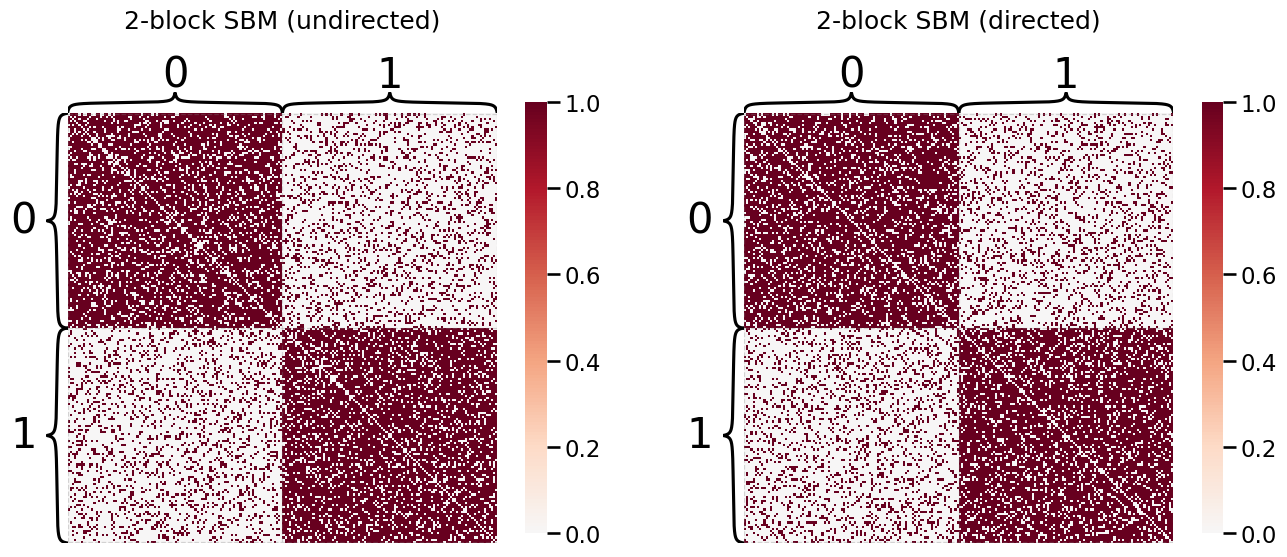

In [2]:
# Define parameters
n_verts = 100
labels_sbm = n_verts * [0] + n_verts * [1]
P = np.array([[0.8, 0.2], 
              [0.2, 0.8]])

# Generate SBMs from parameters
undirected_sbm = sbm(2 * [n_verts], P)
directed_sbm = sbm(2 * [n_verts], P, directed=True)

# Plot both SBMs
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
heatmap(undirected_sbm, title='2-block SBM (undirected)', inner_hier_labels=labels_sbm, ax=axes[0])
heatmap(directed_sbm, title='2-block SBM (directed)', inner_hier_labels=labels_sbm, ax=axes[1]);

## Embedding: Undirected Case

We now use the AdjacencySpectralEmbed class to embed the adjacency matrix into lower-dimensional space.  
If no parameters are given to the AdjacencySpectralEmbed class, it will automatically choose the number of dimensions to embed into.

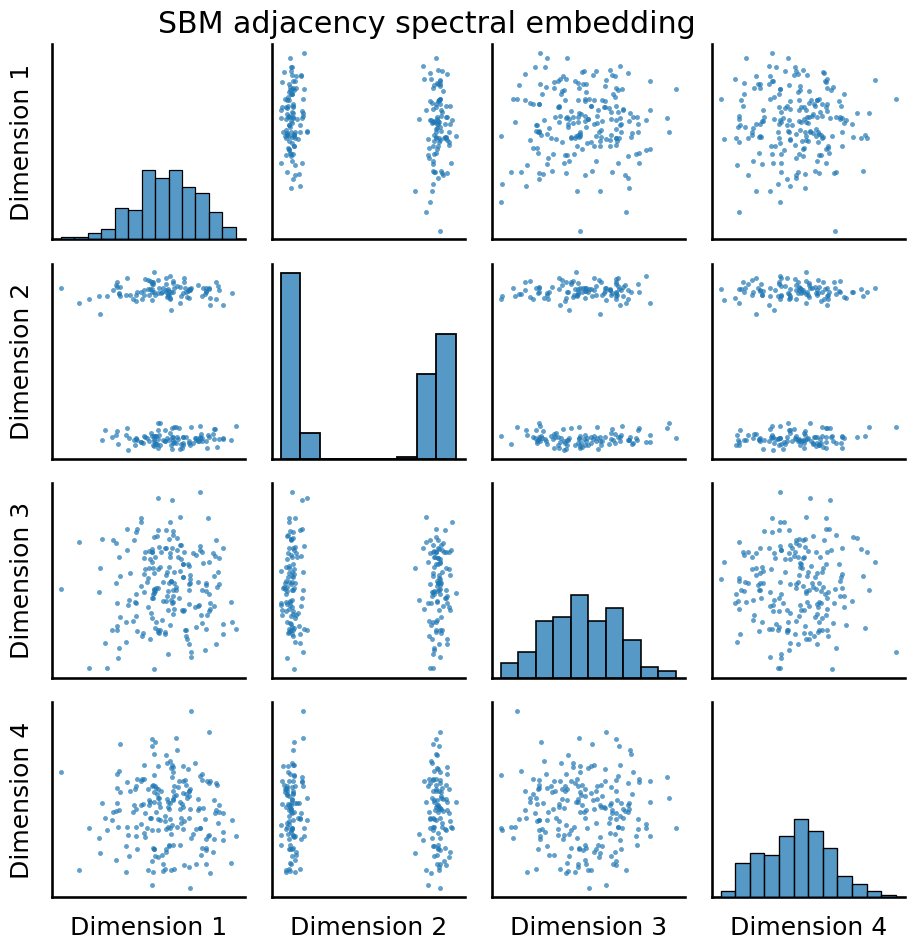

In [3]:
# instantiate an ASE object
ase = AdjacencySpectralEmbed()

# call its fit_transform method to generate latent positions
Xhat = ase.fit_transform(undirected_sbm)
_ = pairplot(Xhat, title='SBM adjacency spectral embedding')

## Embedding: Directed Case

If the graph is directed, we will get two outputs roughly corresponding to the "out" and "in" latent positions, since these are no longer the same. 

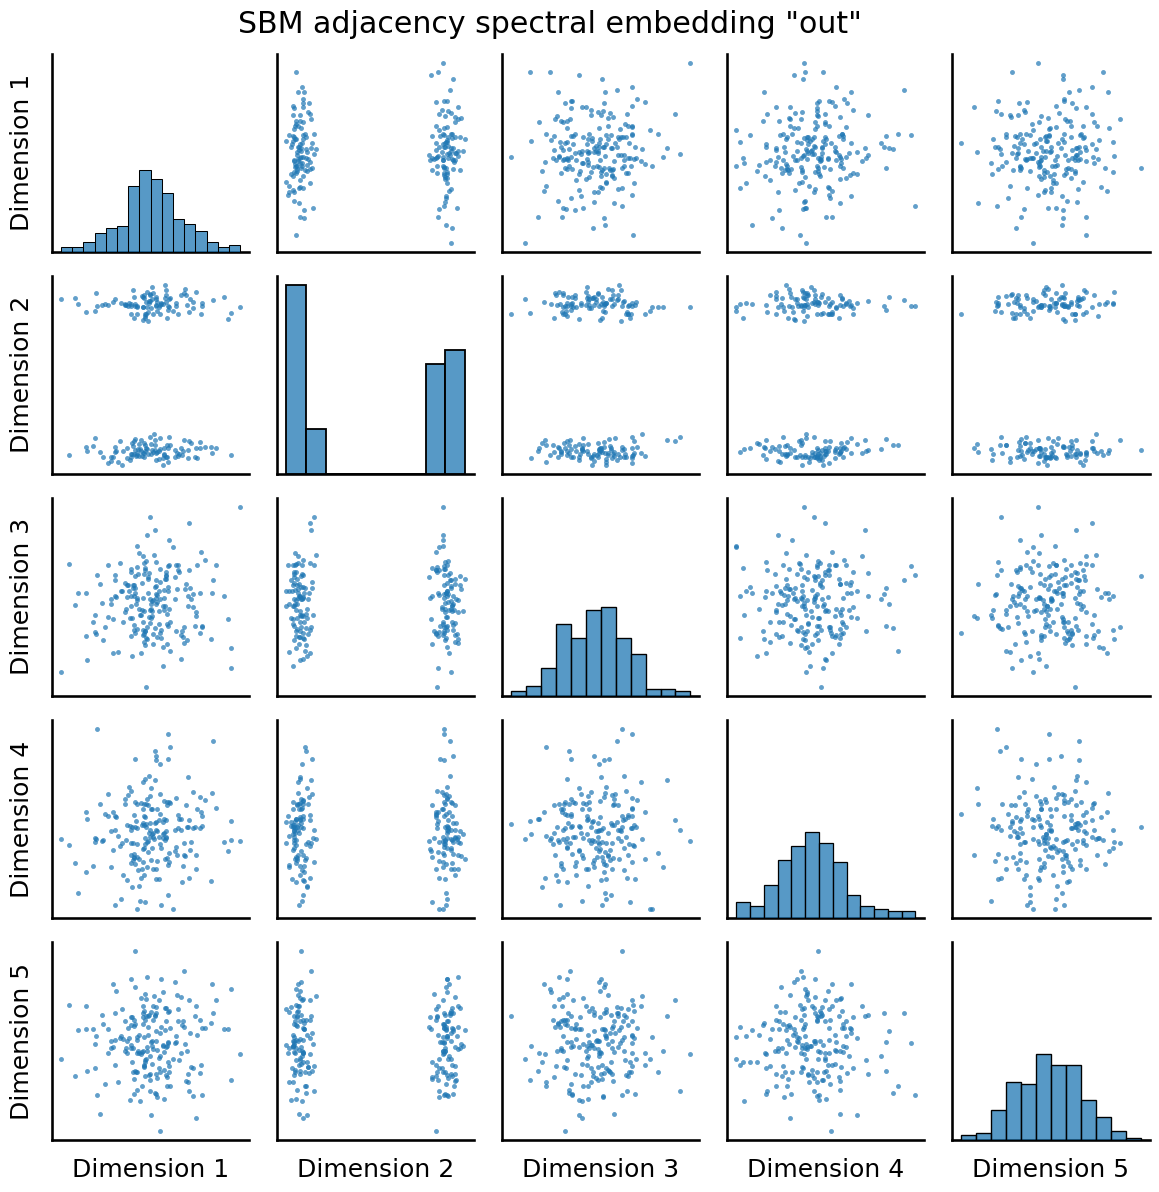

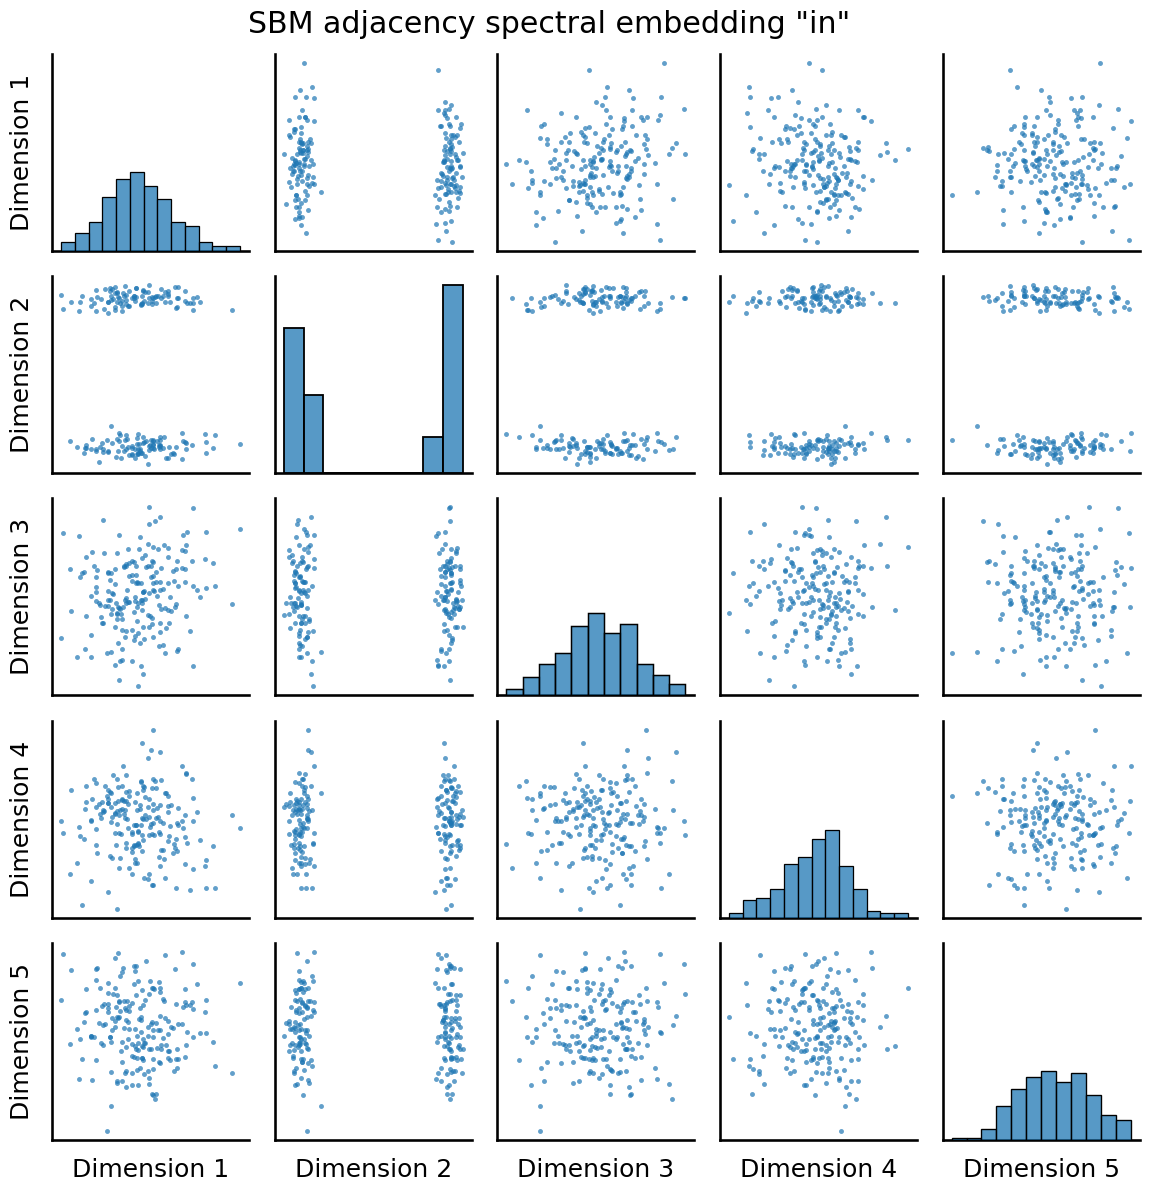

In [4]:
# Transform in directed case
ase = AdjacencySpectralEmbed()
Xhat, Yhat = ase.fit_transform(directed_sbm)

# Plot both embeddings
pairplot(Xhat, title='SBM adjacency spectral embedding "out"')
_ = pairplot(Yhat, title='SBM adjacency spectral embedding "in"')

## Dimension specification

One can also specify the parameters for embedding.  
Here, we specify the number of embedded dimensions and change the SVD solver used to compute the embedding.

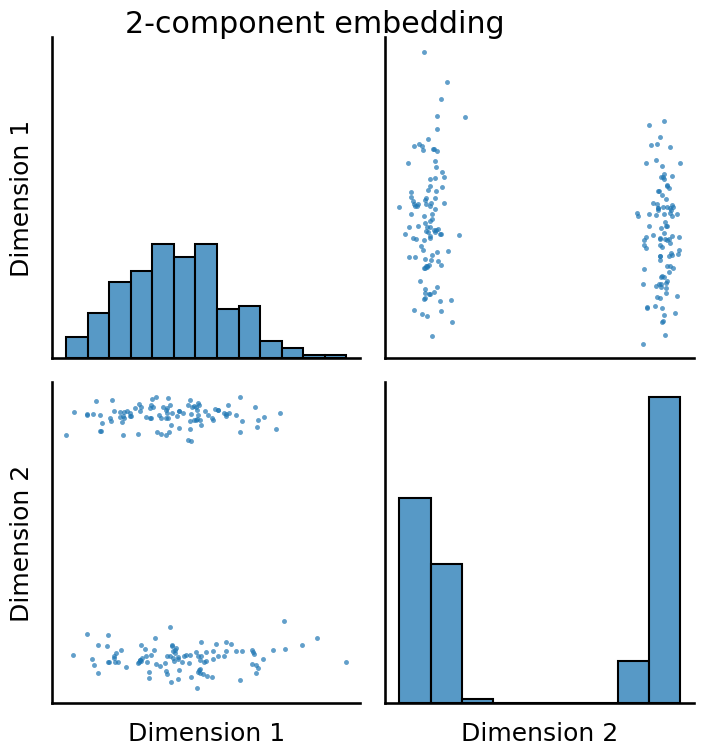

In [5]:
# fit and transform
ase = AdjacencySpectralEmbed(n_components=2, algorithm='truncated')
Xhat = ase.fit_transform(undirected_sbm)

# plot
pairplot(Xhat, title='2-component embedding', height=4)

## Clustering in the embedded space
Now, we will use the Euclidian representation of the graph to apply a standard clustering algorithm like k-means. We start with an SBM model where the 2 blocks have the exact same connection probabilities (effectively giving us an ER model graph). In this case, k-means will not be able to distinguish among the two embedded blocks. As the connections between the blocks become more distinct, the clustering will improve. For each graph, we plot its adjacency matrix, the predicted k-means cluster labels in the embedded space, and the error as a function of the true labels. Adjusted Rand Index (ARI) is a measure of clustering accuracy, where 1 is perfect clustering relative to ground truth. Error rate is simply the proportion of correctly labeled nodes. 

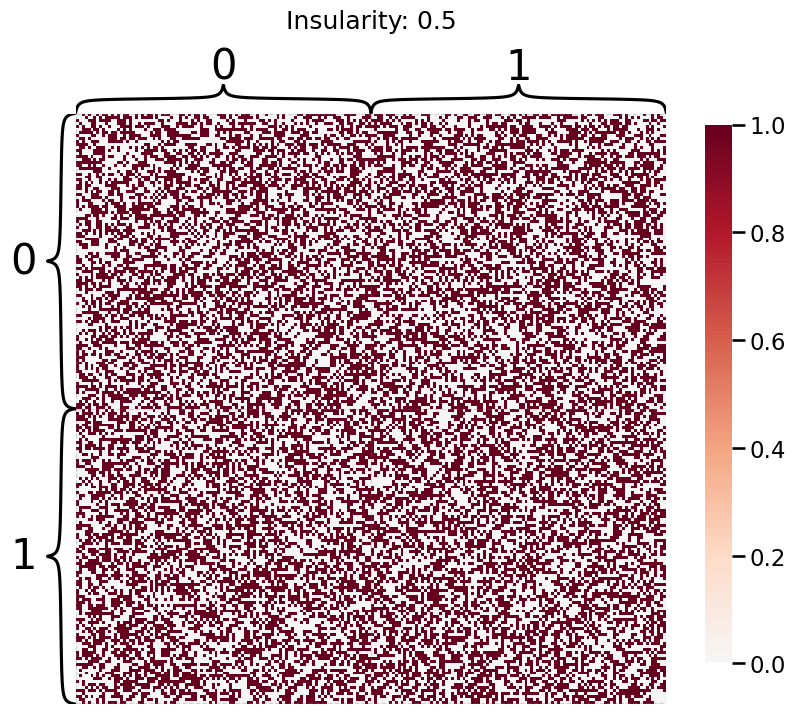

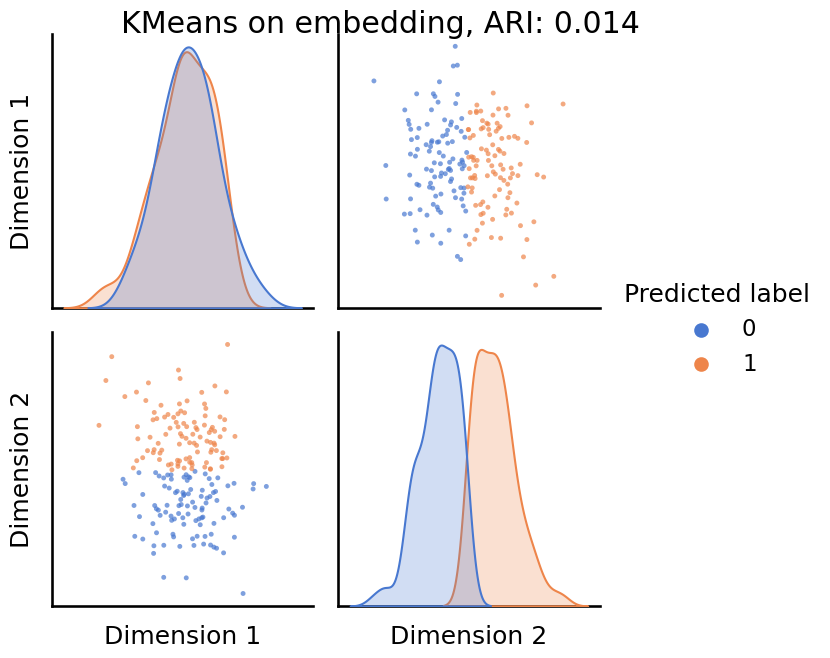

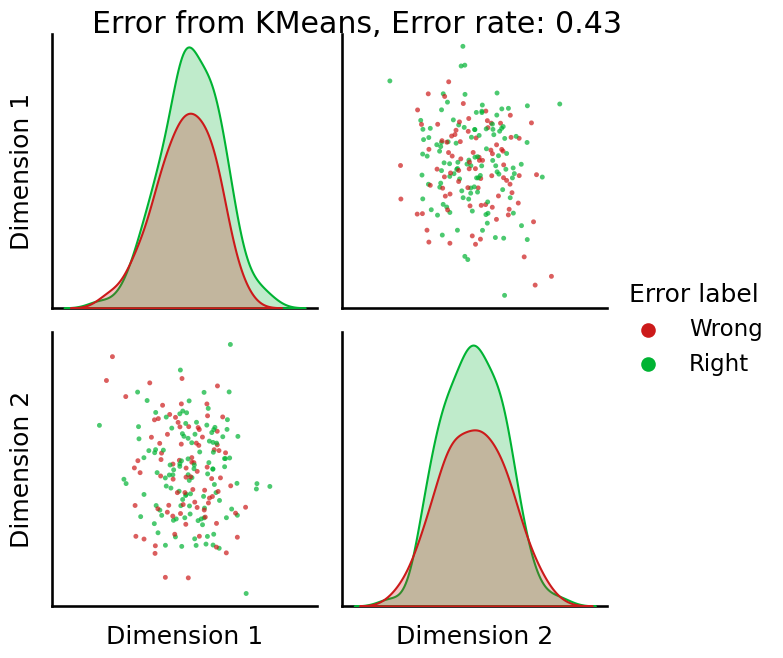

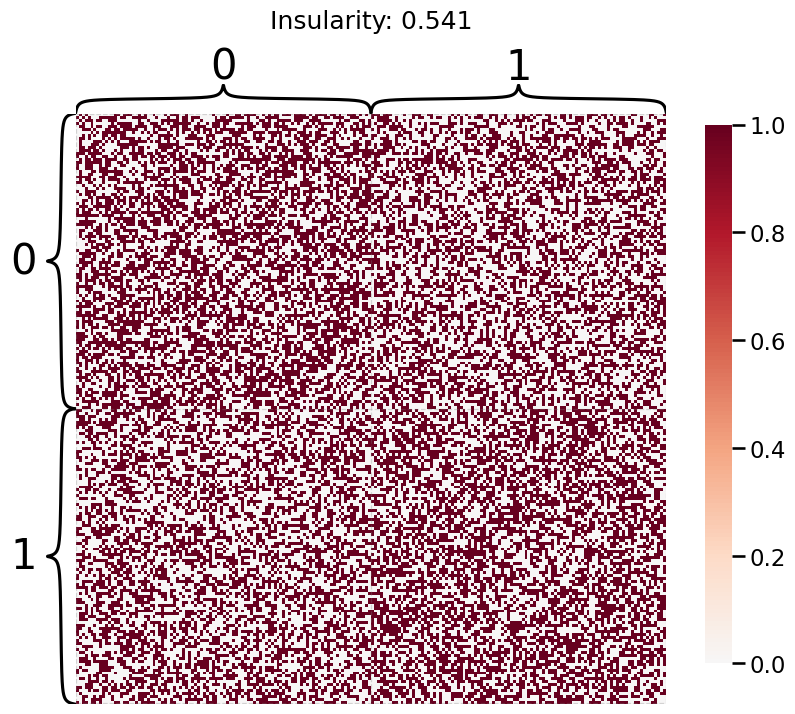

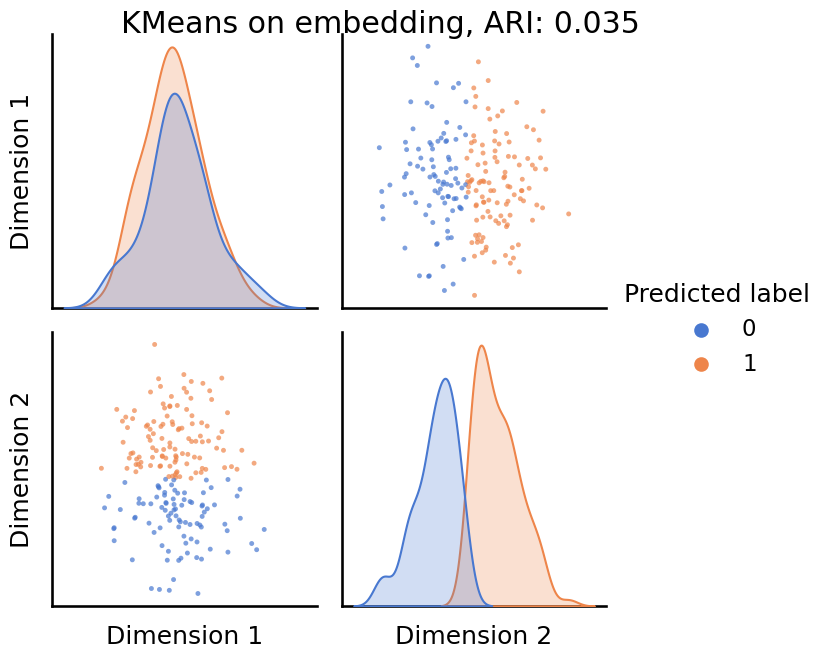

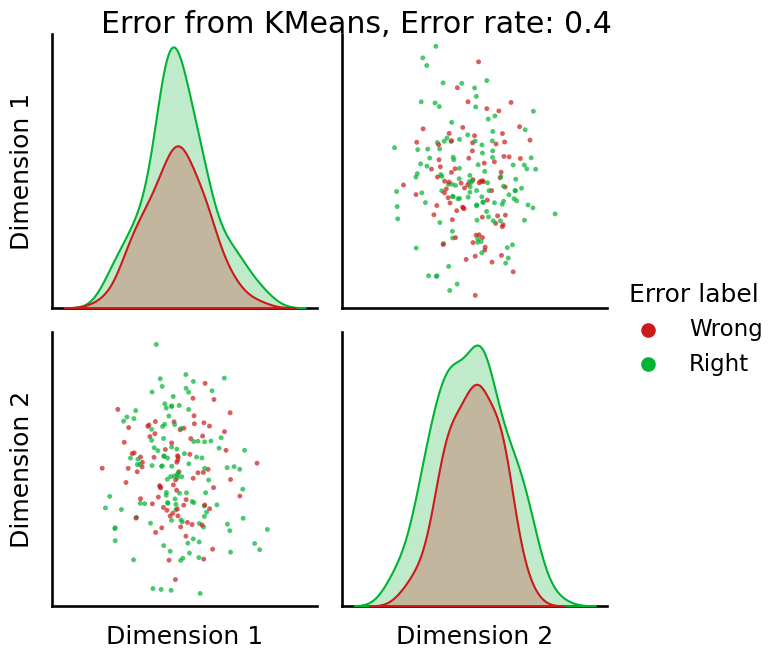

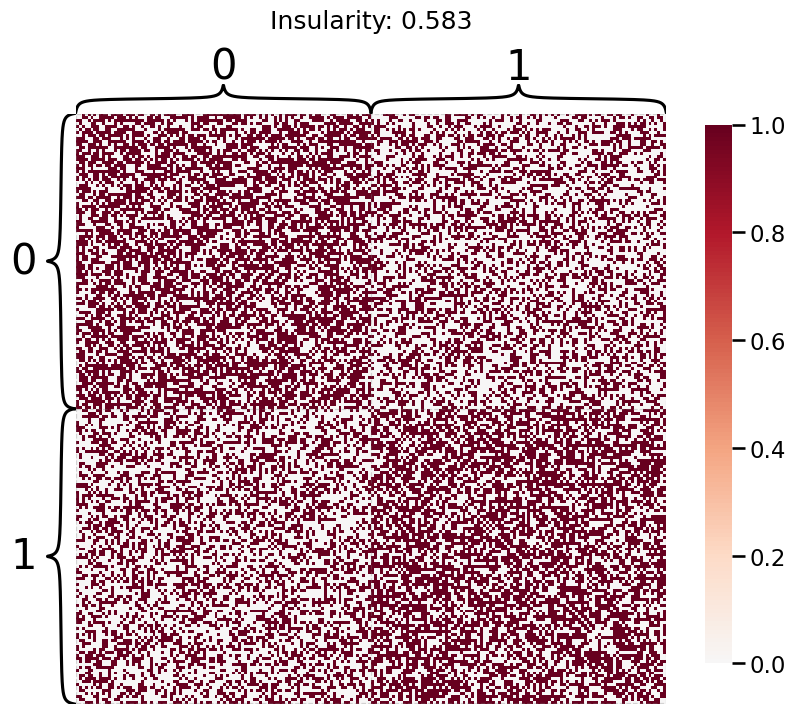

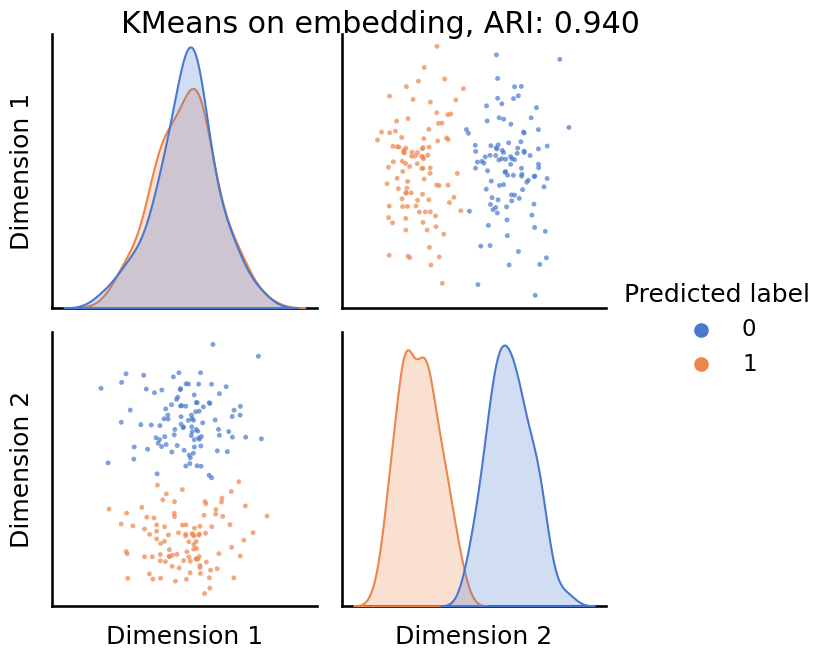

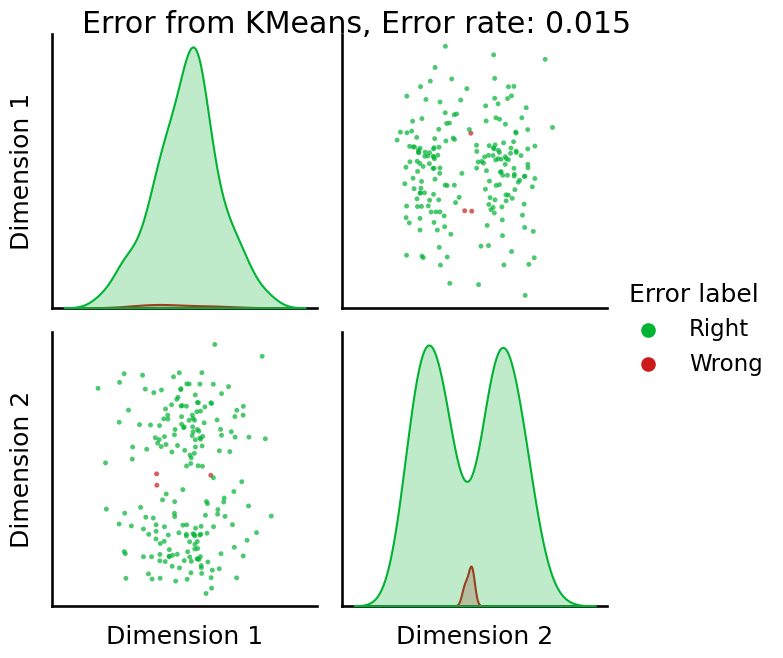

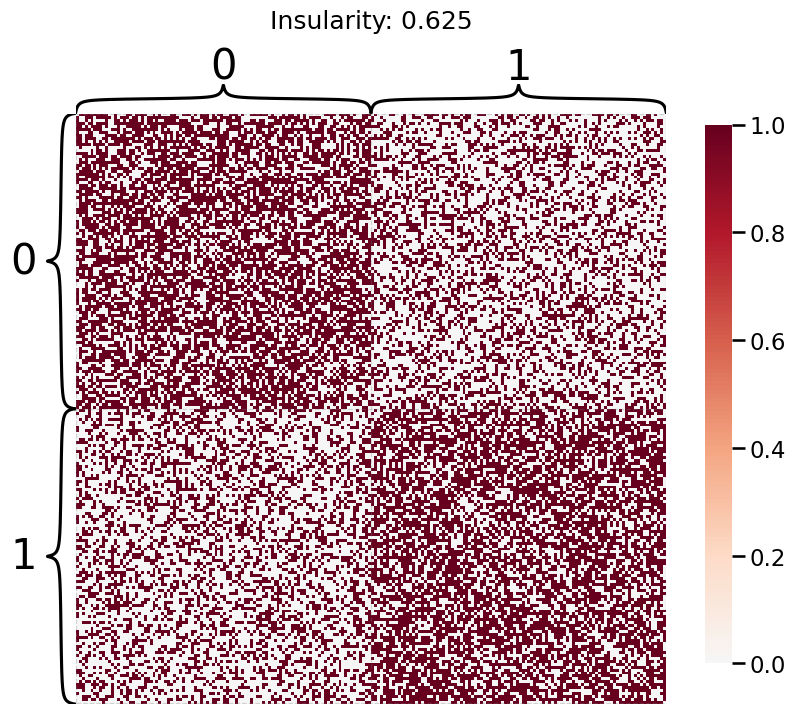

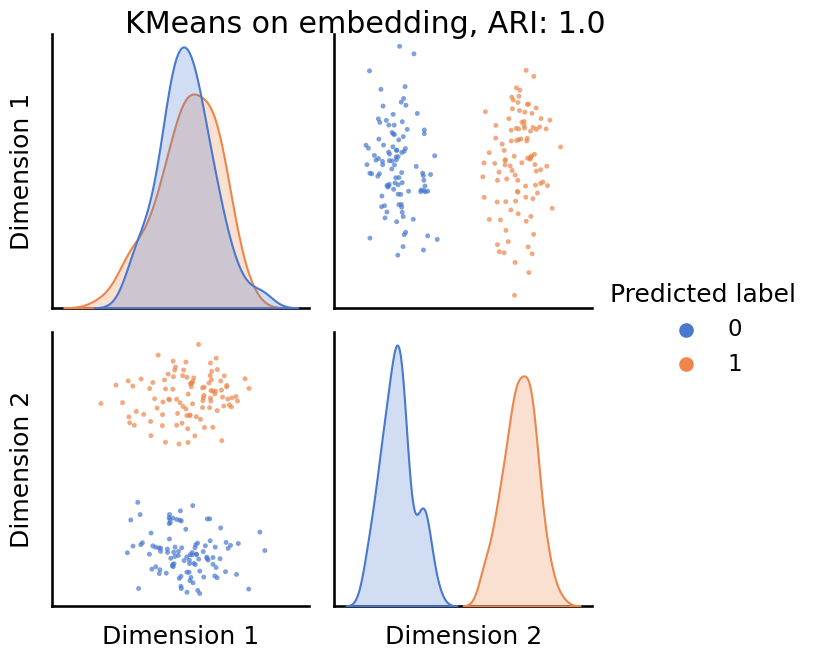

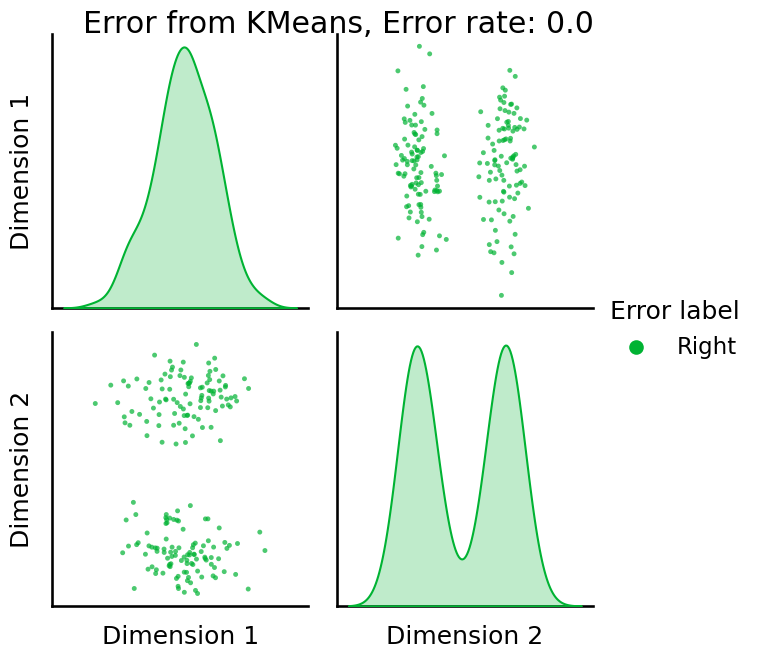

In [6]:
palette = {'Right':(0,0.7,0.2),
           'Wrong':(0.8,0.1,0.1)}

for insularity in np.linspace(0.5, 0.625, 4):
    P = np.array([[insularity, 1-insularity], [1-insularity, insularity]])
    sampled_sbm = sbm(2 * [n_verts], P)
    Xhat = AdjacencySpectralEmbed(n_components=2).fit_transform(sampled_sbm)
    labels_kmeans = KMeans(n_clusters=2).fit_predict(Xhat)
    ari = adjusted_rand_score(labels_sbm, labels_kmeans)
    error = labels_sbm - labels_kmeans
    error = error != 0
    # sometimes the labels given by kmeans will be the inverse of ours
    if np.sum(error) / (2 * n_verts) > 0.5:
        error = error == 0
    error_rate = np.sum(error) / (2 * n_verts)
    error_label = (2 * n_verts) * ['Right']
    error_label = np.array(error_label)
    error_label[error] = 'Wrong'
    
    heatmap(sampled_sbm, title=f'Insularity: {str(insularity)[:5]}', 
            inner_hier_labels=labels_sbm)
    pairplot(Xhat,
             labels=labels_kmeans,
             title=f'KMeans on embedding, ARI: {str(ari)[:5]}',
             legend_name='Predicted label',
             height=3.5,
             palette='muted',)
    pairplot(Xhat,
             labels=error_label,
             title=f'Error from KMeans, Error rate: {str(error_rate)}',
             legend_name='Error label',
             height=3.5,
             palette=palette,)